In [1]:
import scipy.io
from scipy.sparse import random
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# load data from matlab file mackeyglass time series
loaded_mat = scipy.io.loadmat('MGTimeseries_dde23_tau17.mat')
data_tau17 = loaded_mat['MGseries_dde23_tau17'][0]
data_tau50 = loaded_mat['MGseries_dde23_tau50'][0]

# clean dataset
data = pd.DataFrame({'tau17': data_tau17}) # use tau=17 first
data.index = data.index + 1

# split data set
training_data = data.loc[1:3001]
testing_data = data.loc[3002:]

In [39]:
def gen_matrix(shape, sparsity, sd=1, mean=0, seed=100, pdf="gaussian"):
    m = shape[0]
    n = shape[1]
    
    if pdf == "gaussian":
        rvs = stats.norm(loc=mean, scale=sd).rvs
        M = random(m, n, density=sparsity, random_state=seed, data_rvs=rvs).A
        return M
    
    if pdf == "uniform":
        rvs = stats.uniform(loc=mean, scale=sd).rvs
        M = random(m, n, density=sparsity, random_state=seed, data_rvs=rvs).A
        return M
    
    if pdf == "ones":
        M = random(m, n, density = sparsity, random_state=seed, data_rvs=np.ones).A
        return M
    else: 
        print("No such pdf")

def spectral_radius(M):
    max_abs_eigenvalue = -1
    eigenvalues, eigenvectors = np.linalg.eig(M)
    for eigenvalue in eigenvalues:
        if abs(eigenvalue) > max_abs_eigenvalue:
            max_abs_eigenvalue = abs(eigenvalue)
    return max_abs_eigenvalue

def spectral_radius_matrix(M, desired_spec_rad):
    M_sr = spectral_radius(M)
    print("original spectral radius: {}".format(M_sr))
    if M_sr == 0:
        print("new spectral radius: {}".format(M_sr))
        return M
    else:
        M = M*(desired_spec_rad/M_sr)
        print("new spectral radius: {}".format(spectral_radius(M)))
        return M

In [3]:
def sigma(value):
    return np.tanh(value)

# esn - state equation
def state(x_prev, z_curr):
    z_curr = np.atleast_2d(z_curr)
    x_curr = sigma(np.matmul(A, x_prev) + gamma*np.matmul(C, z_curr) + s*zeta)
    return x_curr

# esn - observation equation
def observation(x_curr, w):
    z_next = np.matmul(np.transpose(w), x_curr)
    return z_next

# incrementally store x and actual z values into matrix X and Z, output best weight solution
def regression_sol(ld, remove_init=True):
    result_dict = {'last_state': None,
                   'all_states': None,
                  'best_weight': None,}
    
    for t in range(1, T+1):
        if t == 1:
            x_curr = x_0
            X = np.array(x_curr)
            z_curr = training_data.loc[t]['tau17']
            Z = np.atleast_2d(np.array([z_curr]))
        else:
            x_curr = state(x_curr, z_curr)
            X = np.column_stack((X, x_curr))
            z_curr = training_data.loc[t]['tau17']
            Z = np.column_stack((Z, z_curr))
            
    result_dict['last_state'] = x_curr
    result_dict['all_states'] = X
    
    if remove_init == True:
        X = X[:, 1001:]
        Z = Z[:, 1001:]

    X_transpose = X.transpose()
    Z_transpose = Z.transpose()
    XZ_transpose = np.matmul(X, Z_transpose)
    inverse_term = np.linalg.inv(np.matmul(X, X_transpose) - ld*np.identity(N))
    W_best = np.matmul(inverse_term, XZ_transpose)
    
    result_dict['best_weight'] = W_best 
    
    node = 0
    state_plot, state_ax = plt.subplots(figsize=(20,5))
    state_ax.plot(X[0])
    state_ax.set_title('Plot of States at node {}'.format(node))
    state_ax.set_xlabel('time')
    state_ax.set_ylabel('state of node {}'.format(node))
    
    return result_dict

In [4]:
def prediction(result_dict):
    weight = result_dict.get('best_weight')
    last_state = result_dict.get('last_state')
    testing_error = 0
    
    x_prev = last_state
    for t_bar in range(T+1, T+T_bar+1):
        z_predict = observation(x_prev, weight)[0][0]
        x_prev = state(x_prev, z_predict)
        z_predictions.append(z_predict)

        z_actual = testing_data.loc[t_bar]['tau17']
        testing_error = testing_error + (z_predict - z_actual)**2
        z_actuals.append(z_actual)
        
    return testing_error/(T_bar-1)

def training_error(result_dict):
    weight = result_dict.get('best_weight')
    X = result_dict.get('all_states')
    
    training_error = 0
    
    for t in range(1, T+1):
        x_prev = X[:, t-1]
        z_predict = observation(x_prev, weight)[0]
        
        z_predictions.append(z_predict)
        z_actual = training_data.loc[t]['tau17']
        z_actuals.append(z_actual)
        training_error = training_error + (z_predict - z_actual)**2
        
    return training_error/(T-1)

In [53]:
N = 1000
spars = 0.01

spec_rad = 0.8
A = gen_matrix((N,N), sparsity=spars, sd=2, mean=-1, pdf="uniform")
A = spectral_radius_matrix(A, spec_rad)

gamma = 0.1
C = gen_matrix((N,1), sparsity=spars, sd=2, mean=-1, pdf="uniform")

s = 0.2
zeta = gen_matrix((N, 1), sparsity=spars, pdf="ones")

original spectral radius: 1.860694524035866
new spectral radius: 0.8000000000000034


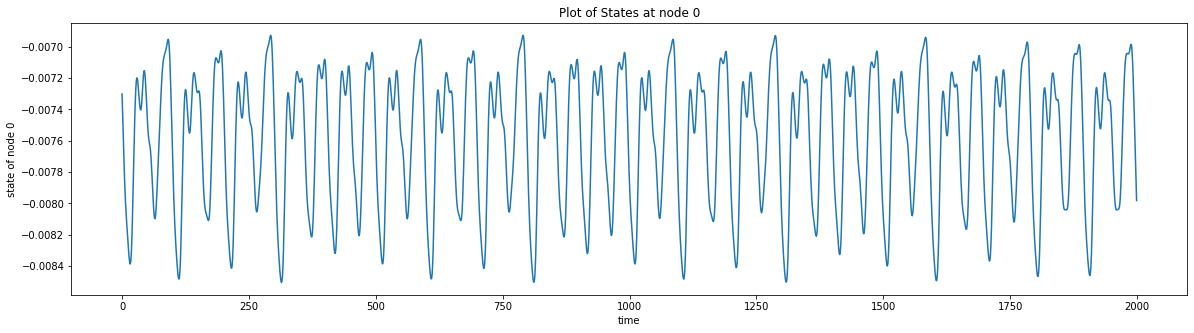

In [54]:
x_0 = np.zeros(shape=(N,1), dtype=float)

T = len(training_data)
T_bar = len(testing_data)

result = regression_sol(0.5, remove_init=True)

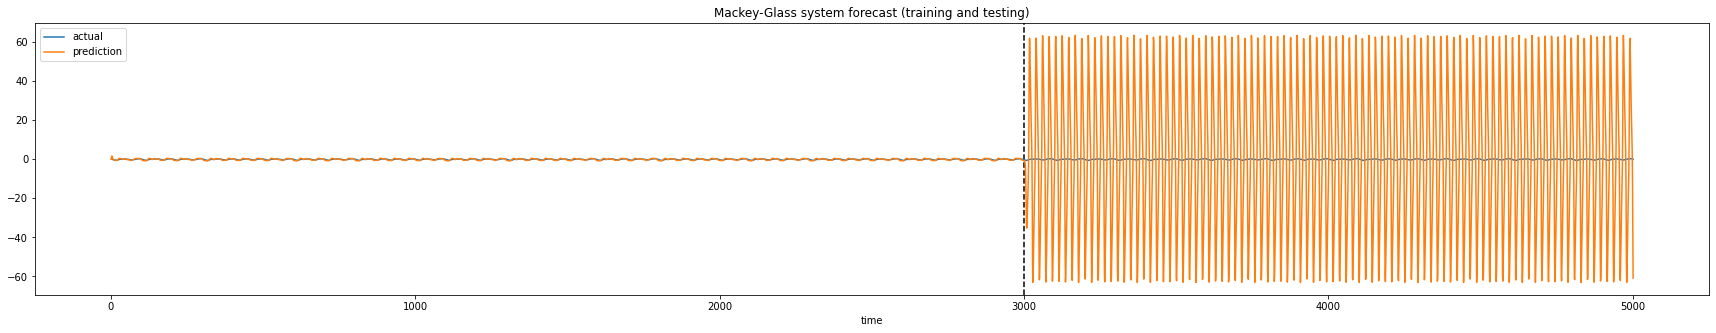

In [55]:
z_predictions = []
z_actuals = []
trained_error = training_error(result)
test_error = prediction(result)

forecast_plot, forecast_ax = plt.subplots(figsize=(30, 5))
forecast_ax.axvline(T, color='black', linestyle="--")
forecast_ax.plot(range(1, T+T_bar+1), z_actuals, label='actual')
forecast_ax.plot(range(1, T+T_bar+1), z_predictions, label='prediction')
forecast_ax.set_title('Mackey-Glass system forecast (training and testing)')
forecast_ax.set_xlabel('time')
forecast_ax.legend()

In [56]:
print('Training error is {}'.format(trained_error))
print('Testing error is {}'.format(test_error))

Training error is 0.05970522962823203
Testing error is 1502.8075875625111
